# MBS Trend Convexity Background Research

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\MBSTrendConvexity\root\src")
sys.path.append(r"/Users/diegoalvarez/Desktop/research/MBSTrendConvexity/root/src")
from MBSDataPrep import DataPrep

## Societe Generale Interest Rate Trend Following

There are well documented resources regarding replication of trend following indices. *Koulajian & Czkwianianc (2010)* at Quest Partners LLC in [Black Box Trend Following – Lifting the Veil](https://www.questpartnersllc.com/downloads/Quest_Research_Series_-_No_1_Trend_Following_-_September_2010.pdf) show that trend following indices can be replicated with 10x100MA signals on futures contracts. A more complex approach is provided by *Dao, Ngyuen, Lempérière, Bouchaud, and Potters* at Capital Fund Management in [Tail protection for long investors: Trend convexity at work](https://arxiv.org/abs/1607.02410) provide a more complex approach to recreating the SG Trend follower index. Their signal is generated via 180d EWMA of nominal differenced futures priced scaled by a volatility constant to account for heteroskedasticity and give the returns unit variance. Their results give 82% replication to SG Trend follower. While *Yang & Qian* at PanAgora Asset Management in [Protecting the Downside of Trend When It Is Not Your Friend](https://www.panagora.com/insights/protecting-the-downside-of-trend-when-it-is-not-your-friend/) give a counter example - implying that sophisticated trend signals provide significant returns versus simplistic trend following models this notebook will include SGI Interest Trend index as well.

In this case the replicating trend follower will use the following methods <br>
1. Strategy consisting of US Treasury Futures
2. 10x100 EWMAC Signal
3. Equal Weight and Equal Volatility Contribution Portfolio Optimization

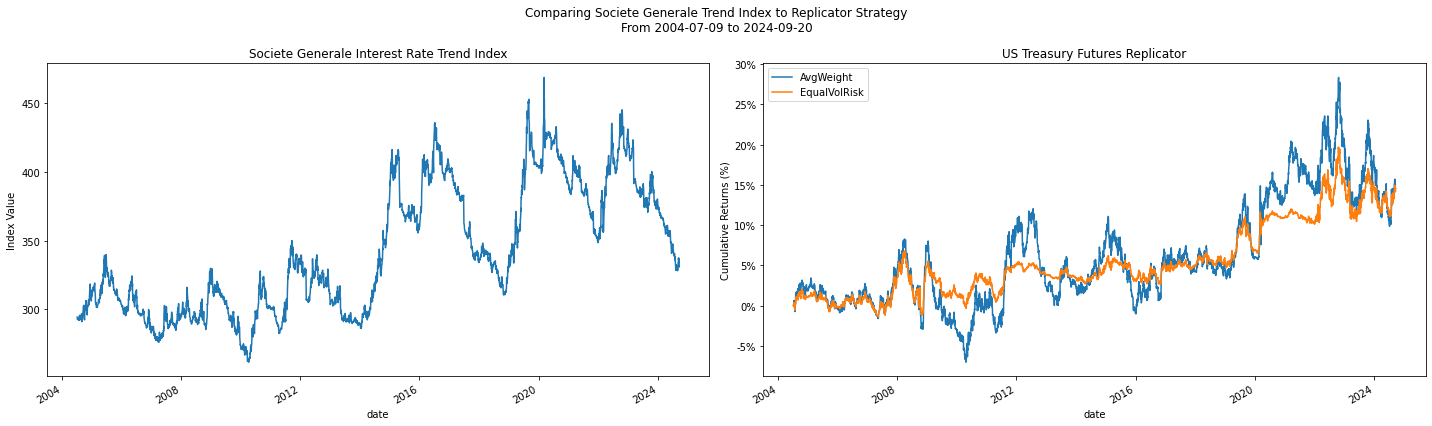

In [3]:
def plot_index_replicator() -> plt.Figure:
    
    df_tmp = DataPrep().replicate_sg_index()
    col_groups = {
        "SG":         ["SocGenTrend"],
        "Replicator": ["AvgWeight", "EqualVolRisk"]}

    fig, axes = plt.subplots(ncols = len(col_groups.keys()), figsize = (20,6))
    for col, ax in zip(col_groups.keys(), axes.flatten()):

        (df_tmp[
            col_groups[col]].
            plot(
                ax = ax))

        if col == "SG": 

            ax.legend().set_visible(False)
            ax.set_ylabel("Index Value")
            ax.set_title("Societe Generale Interest Rate Trend Index")

        else: 

            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x*100:.0f}%"))
            ax.set_ylabel("Cumulative Returns (%)")
            ax.set_title("US Treasury Futures Replicator")

    fig.suptitle("Comparing Societe Generale Trend Index to Replicator Strategy\nFrom {} to {}".format(
        df_tmp.index.min().date(),
        df_tmp.index.max().date()))

    plt.tight_layout()
    
plot_index_replicator()

Now compare the correlation of all strategies. 

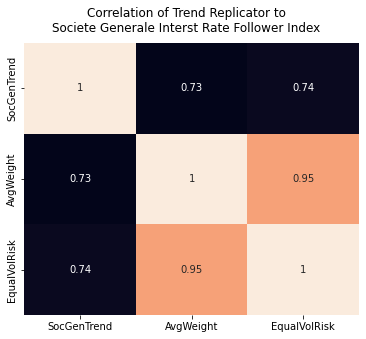

In [4]:
def plot_correlation() -> plt.Figure:
    
    fig, axes = plt.subplots(figsize = (6,5))

    sns.heatmap(
        data  = DataPrep().replicate_sg_index().corr(),
        annot = True,
        cbar  = False,
        ax    = axes)

    fig.suptitle("Correlation of Trend Replicator to\nSociete Generale Interst Rate Follower Index")
    
plot_correlation()

The correlation is considerably high for how generic the replicator is. The correlation is not as good as the ones in within the papers listed likely for the following reasons <br>
1. Uses solely US Treasury Futures
2. Uses generic Trend following techinques
3. Uses simplistic portfolio optimization
4. The index uses some volatility scaling

## The Convexity of Returns

It has been well known that the MBS has negative convexity which is driven by duration extension and prepayment. 

In [5]:
def get_mtge_rate() -> pd.DataFrame: 
    
    df_out = (DataPrep().get_misc().query(
        "security == '.30CC105'").
        pivot(index = "date", columns = "security", values = "value").
        rename(columns = {".30CC105": "mtge_rate"}))

    return df_out

df_mtge = get_mtge_rate()

In [6]:
def prep_mtge_rate(df_mtge: pd.DataFrame, window: int = 30) -> pd.DataFrame: 

    df_out = (df_mtge.sort_index().assign(
        mtge_diff = lambda x: x.mtge_rate.diff(periods = window),
        mtge_signal = lambda x: x.mtge_rate.diff().ewm(span = window).mean().shift()).
        reset_index().
        drop(columns = ["mtge_rate"]).
        melt(id_vars = "date").
        dropna())

    return df_out

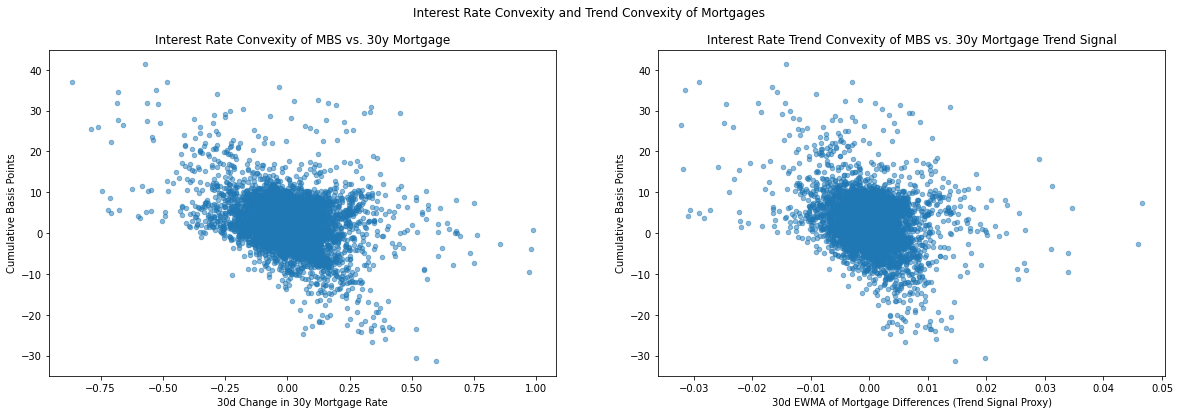

In [7]:
def plot_mtge_rate_conexity(df_mtge: pd.DataFrame, window: int = 30) -> plt.Figure: 

    df_mtge_signal = prep_mtge_rate(df_mtge)
    df_plot = (DataPrep().get_mtge_data()[
        ["px_bps"]].
        sort_index().
        rolling(window = 30).
        sum().
        dropna().
        merge(right = df_mtge_signal, how = "inner", on = ["date"]))
    
    xlabel_namer = {
        "mtge_diff"  : "30d Change in 30y Mortgage Rate",
        "mtge_signal": "30d EWMA of Mortgage Differences (Trend Signal Proxy)"}
    
    title_namer = {
        "mtge_diff"  : "Interest Rate Convexity of MBS vs. 30y Mortgage",
        "mtge_signal": "Interest Rate Trend Convexity of MBS vs. 30y Mortgage Trend Signal"}
    
    variables = df_plot.security.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))
    
    for variable, ax in zip(variables, axes.flatten()):
    
        (df_plot.query(
            "security == @variable").
            plot(
                alpha  = 0.5,
                ax     = ax,
                kind   = "scatter",
                x      = "value",
                y      = "px_bps",
                ylabel = "Cumulative Basis Points",
                title  = title_namer[variable],
                xlabel = xlabel_namer[variable]))

    fig.suptitle("Interest Rate Convexity and Trend Convexity of Mortgages")

plot_mtge_rate_conexity(df_mtge)

While the returns of the trend follower has positive convexity.

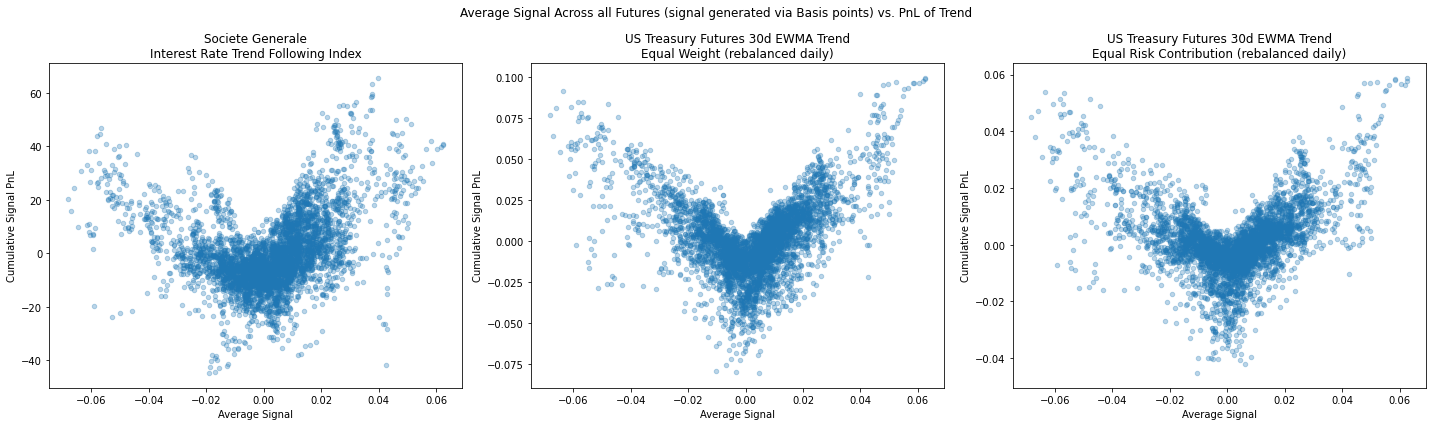

In [8]:
def plot_ewma_signal() -> plt.Figure: 

    df_signal = (DataPrep().get_tsy_signal()[
        ["date", "lag_signal"]].
        groupby("date").
        agg("mean"))
    
    df_plot = (DataPrep().replicate_sg_index().diff().rolling(
        window = 30).
        sum().
        reset_index().
        melt(id_vars = "date").
        dropna().
        merge(right = df_signal, how = "inner", on = ["date"]))
    
    variables = df_plot.variable.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))
    renamer = {
        "SocGenTrend" : "Societe Generale\nInterest Rate Trend Following Index",
        "AvgWeight"   : "US Treasury Futures 30d EWMA Trend\nEqual Weight (rebalanced daily)",
        "EqualVolRisk": "US Treasury Futures 30d EWMA Trend\nEqual Risk Contribution (rebalanced daily)"}
    
    for variable, ax in zip(variables, axes.flatten()):
    
        (df_plot.query(
            "variable == @variable").
            plot(
                kind   = "scatter",
                x      = "lag_signal",
                y      = "value", 
                ax     = ax,
                alpha  = 0.3,
                ylabel = "Cumulative Signal PnL",
                xlabel = "Average Signal",
                title  = renamer[variable]))

    fig.suptitle("Average Signal Across all Futures (signal generated via Basis points) vs. PnL of Trend")
    plt.tight_layout()

plot_ewma_signal()

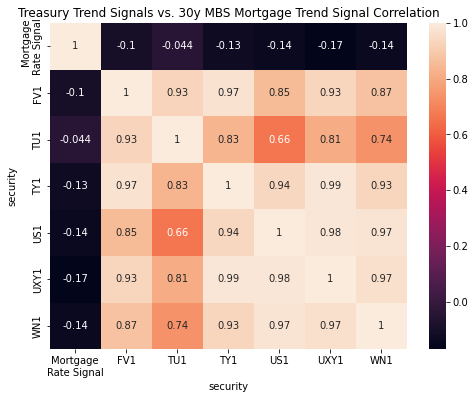

In [9]:
def plot_signal_correlation(df_mtge: pd.DataFrame) -> plt.Figure:

    df_rate = df_mtge.sort_index().diff(periods = 30)
    
    df_tsy_signal = (DataPrep().get_tsy_signal()[
        ["date", "security", "lag_signal"]].
        pivot(index = "date", columns = "security", values = "lag_signal"))
    
    df_corr = (prep_mtge_rate(
        df_mtge).
        query("security == 'mtge_signal'").
        replace({"mtge_signal": "Mortgage\nRate Signal"}).
        pivot(index = "date", columns = "security", values = "value").
        merge(right = df_tsy_signal, how = "inner", on = ["date"]).
        corr())
    
    fig, axes = plt.subplots(figsize = (8,6))
    
    sns.heatmap(
        data  = df_corr,
        annot = True,
        ax    = axes)
    
    axes.set_title("Treasury Trend Signals vs. 30y MBS Mortgage Trend Signal Correlation")

plot_signal_correlation(df_mtge)

They are slightly related in this case. Recally that the MBS trend signal is designed based on rates rather than price which is how the futures are generated which is why they are negative. MBS has negative convexity to rates and negative convexity to rates trend signal, but don't share much of the trend returns convexity that the Treasury Futures have.